In [37]:
pip install --user tf-nightly


  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
     ------------------------------------- 438.9/438.9 kB 13.8 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.2 requires absl-py~=0.10, but you have absl-py 1.1.0 which is incompatible.
tensorflow-gpu 2.6.2 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.
tensorflow-gpu 2.6.2 requires numpy~=1.19.2, but you have numpy 1.23.0 which is incompatible.
tensorflow-gpu 2.6.2 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.8.0 which is incompatible.
tensorflow-gpu 2.6.2 requires tensorflow-estimator<2.7,>=2.6.0, but you have tensorflow-estimator 2.9.0 which is incompatible.


In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [39]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [40]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


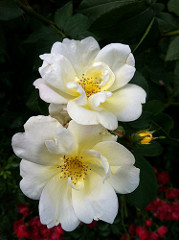

In [41]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

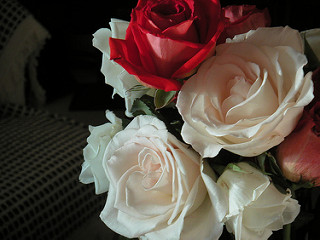

In [42]:
PIL.Image.open(str(roses[1]))

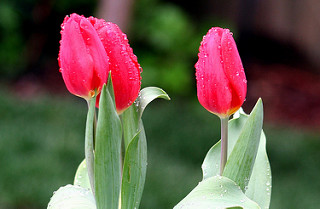

In [43]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

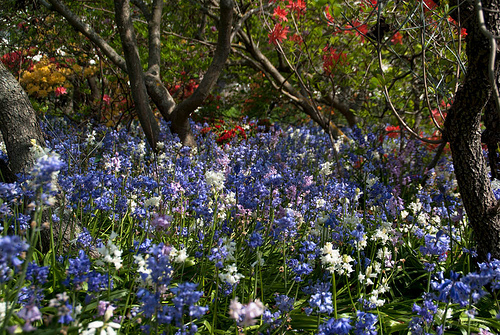

In [44]:
PIL.Image.open(str(tulips[1]))

In [45]:
batch_size = 32
img_height = 180
img_width = 180

In [46]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [48]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


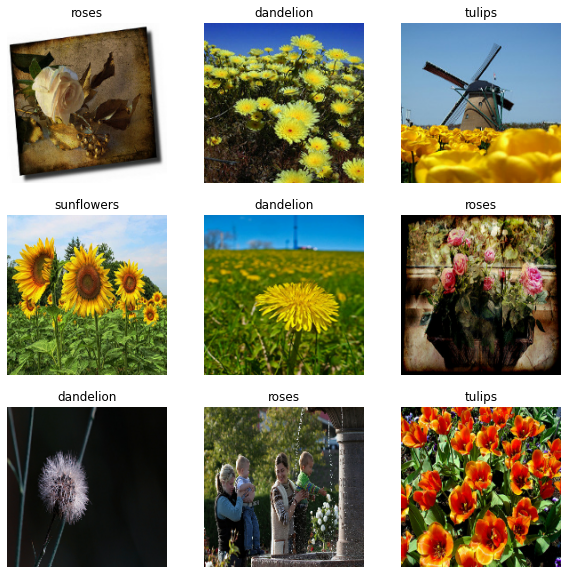

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [50]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [53]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [54]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

AttributeError: module 'tensorflow.compat.v2.__internal__.tracking' has no attribute 'TrackableSaver'

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 6s 29ms/step - loss: 1.3027 - accuracy: 0.4445 - val_loss: 1.0498 - val_accuracy: 0.5681
Epoch 2/10
92/92 [==============================] - 1s 15ms/step - loss: 0.9630 - accuracy: 0.6260 - val_loss: 0.9438 - val_accuracy: 0.6294
Epoch 3/10
92/92 [==============================] - 1s 14ms/step - loss: 0.7902 - accuracy: 0.7030 - val_loss: 0.8781 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 1s 14ms/step - loss: 0.6095 - accuracy: 0.7708 - val_loss: 0.8669 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 1s 14ms/step - loss: 0.3885 - accuracy: 0.8638 - val_loss: 0.9415 - val_accuracy: 0.6771
Epoch 6/10
92/92 [==============================] - 1s 14ms/step - loss: 0.2135 - accuracy: 0.9302 - val_loss: 1.2572 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 1s 14ms/step - loss: 0.0937 - accuracy: 0.9741 - val_loss: 1.4951 - val_accuracy: 0.6294
Epoch 8/10
92

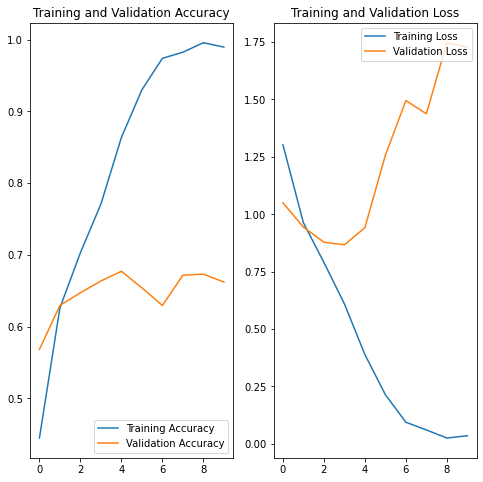

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

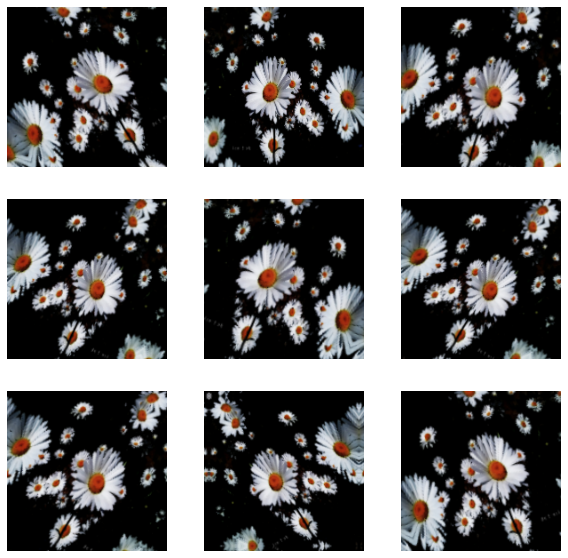

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 17s 160ms/step - loss: 1.3282 - accuracy: 0.4332 - val_loss: 1.1582 - val_accuracy: 0.4809
Epoch 2/15
92/92 [==============================] - 15s 167ms/step - loss: 1.0451 - accuracy: 0.5725 - val_loss: 1.0015 - val_accuracy: 0.6104
Epoch 3/15
92/92 [==============================] - 15s 162ms/step - loss: 0.9334 - accuracy: 0.6260 - val_loss: 0.9260 - val_accuracy: 0.6390
Epoch 4/15
92/92 [==============================] - 14s 155ms/step - loss: 0.8434 - accuracy: 0.6751 - val_loss: 0.8631 - val_accuracy: 0.6798
Epoch 5/15
92/92 [==============================] - 15s 163ms/step - loss: 0.7826 - accuracy: 0.6986 - val_loss: 0.9096 - val_accuracy: 0.6635
Epoch 6/15
92/92 [==============================] - 15s 159ms/step - loss: 0.7361 - accuracy: 0.7105 - val_loss: 0.8456 - val_accuracy: 0.6785
Epoch 7/15
92/92 [==============================] - 15s 163ms/step - loss: 0.6924 - accuracy: 0.7360 - val_loss: 0.7873 - val_accuracy: 0.7071

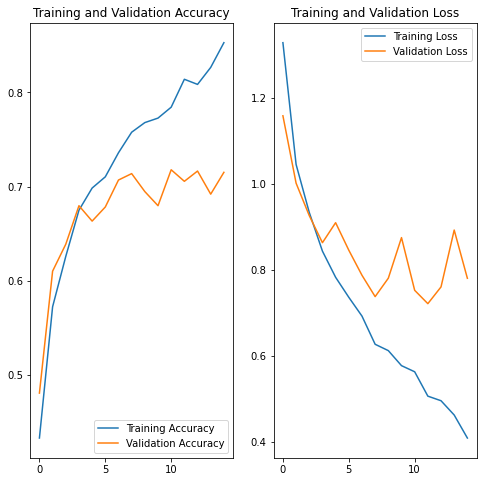

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 325ms/step
This image most likely belongs to sunflowers with a 99.94 percent confidence.
